## Notebook for applying Data Assimilation on seasonal data (PWP reconstructions)

### Assemble data in the proxy domain

Author: **N.J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assistant Professor Vrije Universiteit Amsterdam

**References used in coding**
- Steiger, N.J., Hakim, G.J., Steig, E.J., Battisti, D.S., Roe, G.H., 2014. Assimilation of Time-Averaged Pseudoproxies for Climate Reconstruction. Journal of Climate 27, 426–441. https://doi.org/10.1175/JCLI-D-12-00693.1
- Hakim, G.J., Emile-Geay, J., Steig, E.J., Noone, D., Anderson, D.M., Tardif, R., Steiger, N., Perkins, W.A., 2016. The last millennium climate reanalysis project: Framework and first results. Journal of Geophysical Research: Atmospheres 121, 6745–6764. https://doi.org/10.1002/2016JD024751
- King, J., Tierney, J., Osman, M., Judd, E.J., Anchukaitis, K.J., 2023. DASH: a MATLAB toolbox for paleoclimate data assimilation. Geoscientific Model Development 16, 5653–5683. https://doi.org/10.5194/gmd-16-5653-2023
- Judd, E.J., Tierney, J.E., Lunt, D.J., Montañez, I.P., Huber, B.T., Wing, S.L., Valdes, P.J., 2024. A 485-million-year history of Earth’s surface temperature. Science 385, eadk3705. https://doi.org/10.1126/science.adk3705

# Load packages

In [31]:
# Load packages
import numpy as np # The 'numpy' package is needed for matrix operations and calculations
import pandas as pd # The 'pandas' package helps us to import and manage data
import math as math # Math package for data cleaning
from scipy import stats # Import scipy.package for confidence intervals
from sklearn.preprocessing import StandardScaler # Import the package for standardizing data
import D47calib as D47c # Import the package for treating clumped isotope data by Daëron and Vermeesch (2023; https://github.com/mdaeron/D47calib)
import matplotlib.pyplot as plt # The 'matplotlib' package contains tools needed to plot our data and results
import seaborn as sns # The 'seaborn' package is used to make our plots look nicer (e.g. enable heatmaps)
import warnings # The 'warnings' package is used to suppress warnings that might occur during the calculations
%matplotlib inline

# PRIOR - MONTHLY
## Load monthly SST model data

In [32]:
# Load model SST data as prior and show data structure
PlioMIP_SST = pd.read_csv('PWP case/PlioMIP_SST.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PlioMIP_SST.head()

,modelname,ja,fb,mr,ar,my,jn,jl,ag,sp,ot,nv,dc
0,CCSM4-UoT,8.33,7.14,7.45,9.67,13.33,18.40,22.50,24.35,22.60,18.74,14.83,10.86
1,CCSM4-Utr,9.96,8.75,8.95,11.03,14.62,19.37,23.50,25.29,23.95,20.76,16.37,12.48
2,COSMOS,7.91,6.68,6.38,7.34,9.53,12.23,14.95,15.94,14.94,13.34,11.49,9.58
3,EC-Earth3.3,9.18,7.62,7.41,9.32,13.58,19.22,24.06,25.27,23.56,20.26,16.05,12.13
4,GISS2.1G,4.87,3.58,3.88,6.75,11.21,15.56,18.68,19.39,17.68,14.47,10.53,7.18


## Load monthly SAT model data

In [33]:
# Load model SAT data as prior and show data structure
PlioMIP_SAT = pd.read_csv('PWP case/PlioMIP_SAT.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PlioMIP_SAT.head()

,modelname,ja,fb,mr,ar,my,jn,jl,ag,sp,ot,nv,dc
0,CCSM4,8.39,8.81,9.63,12.05,15.15,19.61,22.81,22.96,19.02,14.70,11.03,9.13
1,CCSM4-UoT,6.97,7.58,9.96,12.54,16.46,21.92,25.43,24.72,19.69,14.32,9.94,7.02
2,CCSM4-Utr,9.43,9.50,10.88,13.14,16.81,21.09,25.02,24.99,21.79,17.26,12.84,10.15
3,CESM1.2,9.32,9.84,10.56,13.06,16.71,20.91,23.83,23.44,20.11,15.96,12.77,10.38
4,CESM2,10.70,10.44,11.75,13.85,17.69,22.31,25.02,25.18,21.79,17.65,13.99,12.05


### Combine SST and SAT data by modelname

In [34]:
# Merge the datasets of SST and SAT, force suffixes to be added to the column names
PlioMIP_monthly = pd.merge(
    PlioMIP_SST.rename(columns = {c: c+'_SST' for c in PlioMIP_SST.columns if c != 'modelname'}),
    PlioMIP_SAT.rename(columns = {c: c+'_SAT' for c in PlioMIP_SAT.columns if c != 'modelname'}),
    on = 'modelname',
    how = 'outer'
)

# Display the combined dataset
PlioMIP_monthly.head()

,modelname,ja_SST,fb_SST,mr_SST,ar_SST,my_SST,jn_SST,jl_SST,ag_SST,sp_SST,...,mr_SAT,ar_SAT,my_SAT,jn_SAT,jl_SAT,ag_SAT,sp_SAT,ot_SAT,nv_SAT,dc_SAT
0,CCSM4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.63,12.05,15.15,19.61,22.81,22.96,19.02,14.70,11.03,9.13
1,CCSM4-UoT,8.33,7.14,7.45,9.67,13.33,18.40,22.5,24.35,22.60,...,9.96,12.54,16.46,21.92,25.43,24.72,19.69,14.32,9.94,7.02
2,CCSM4-Utr,9.96,8.75,8.95,11.03,14.62,19.37,23.5,25.29,23.95,...,10.88,13.14,16.81,21.09,25.02,24.99,21.79,17.26,12.84,10.15
3,CESM1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.56,13.06,16.71,20.91,23.83,23.44,20.11,15.96,12.77,10.38
4,CESM2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.75,13.85,17.69,22.31,25.02,25.18,21.79,17.65,13.99,12.05


### Convert SST model data to D47 domain using the regression by Daëron and Vermeesch (2023) and propagate uncertainty in the calibration

In [35]:
# Apply T47()-function from the D47calib package to all SST columns
# Identify the SST columns
SST_columns = [col for col in PlioMIP_monthly.columns if col.endswith('_SST')]

# Apply the conversion function to the SST columns and add new columns for D47 and D47_SE
for col in SST_columns:
    base_col_name = col.replace('_SST', '') # Remove the '_SST' suffix from the column name
    PlioMIP_monthly[f'{base_col_name}_D47'], PlioMIP_monthly[f'{base_col_name}_D47_SE'] = zip(*PlioMIP_monthly[col].apply(
        lambda x: D47c.OGLS23.T47(T = x) if not pd.isna(x) else (np.nan, np.nan)
    )) # Use zip() to unpack the tuple returned by the apply() method and apply the T47()-function to each value in the column

# Display the combined data with D47 and D47_SE columns
PlioMIP_monthly.head()

,modelname,ja_SST,fb_SST,mr_SST,ar_SST,my_SST,jn_SST,jl_SST,ag_SST,sp_SST,...,ag_D47,ag_D47_SE,sp_D47,sp_D47_SE,ot_D47,ot_D47_SE,nv_D47,nv_D47_SE,dc_D47,dc_D47_SE
0,CCSM4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CCSM4-UoT,8.33,7.14,7.45,9.67,13.33,18.40,22.5,24.35,22.60,...,0.595364,0.001059,0.600724,0.001072,0.612897,0.001114,0.625741,0.001177,0.639340,0.001262
2,CCSM4-Utr,9.96,8.75,8.95,11.03,14.62,19.37,23.5,25.29,23.95,...,0.592525,0.001054,0.596581,0.001062,0.606465,0.001090,0.620618,0.001150,0.633721,0.001225
3,CESM1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CESM2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate the monthly prior for model SST-derived D47 values with propagated uncertainty

In [36]:
# Create list of month names
months = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']

# Calculate the mean and standard deviation of the entire D47 data
mean_D47 = PlioMIP_monthly[[f"{month}_D47" for month in months]].stack().mean()
std_D47 = PlioMIP_monthly[[f"{month}_D47" for month in months]].stack().std(ddof=1)

# Standardize the entire D47 data
standardized_D47_monthly = (PlioMIP_monthly[[f"{month}_D47" for month in months]] - mean_D47) / std_D47

# Set the weights of the data based on the standard errors
weights_monthly = 1 / PlioMIP_monthly[[f"{month}_D47_SE" for month in months]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_monthly to match the headers of the D47 matrix later for multiplication
weights_monthly.columns = [col.replace('_D47_SE', '_D47') for col in weights_monthly.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_D47_monthly = np.array((standardized_D47_monthly * weights_monthly).sum(axis = 0, skipna = True) / weights_monthly.sum(axis = 0, skipna = True))  # Calculate weighted monthly mean D47 values and convert to numpy array

# Standardize the measurement variances
measurement_variances_monthly = ((PlioMIP_monthly[[f"{month}_D47_SE" for month in months]] ** 2).mean(axis = 0, skipna = True))  # Compute variance on measurements in D47 space
model_variances_monthly = np.diag(np.cov(PlioMIP_monthly[[f"{month}_D47" for month in months]].dropna(), rowvar = False))  # Extract the diagonal terms of the covariance matrix (variances of the models) in D47 space

# Covariance between months in prior D47 estimates from climate models (weighted covariance matrix)
cov_prior_D47_monthly = np.cov(standardized_D47_monthly.dropna(), rowvar = False)  # Compute the covariance matrix for the standardized data (without measurement uncertainty)
combined_variances_monthly = model_variances_monthly + measurement_variances_monthly  # Add the measurement variances to the model variances
np.fill_diagonal(cov_prior_D47_monthly, combined_variances_monthly / std_D47 ** 2)  # Add diagonal terms for measurement uncertainties (which have no covariance between models) and standardize

# Store copy of original prior means to keep when later updating the prior
mu_prior_D47_monthly_original, cov_prior_D47_monthly_original = mu_prior_D47_monthly.copy(), cov_prior_D47_monthly.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_D47_monthly = np.sqrt(np.diag(cov_prior_D47_monthly))

print(mu_prior_D47_monthly)
print(std_prior_D47_monthly)

[ 0.93433536  1.13575615  1.12771802  0.80426242  0.17546116 -0.61878362
 -1.25570064 -1.43026313 -1.14076269 -0.60478467  0.00885138  0.55080731]
[0.32821476 0.34105703 0.32631826 0.27949796 0.32671424 0.44615428
 0.52701443 0.56258066 0.56917985 0.52182807 0.43031941 0.35522476]


## Plot the monthly prior for model SST-derived D47 values with propagated uncertainty

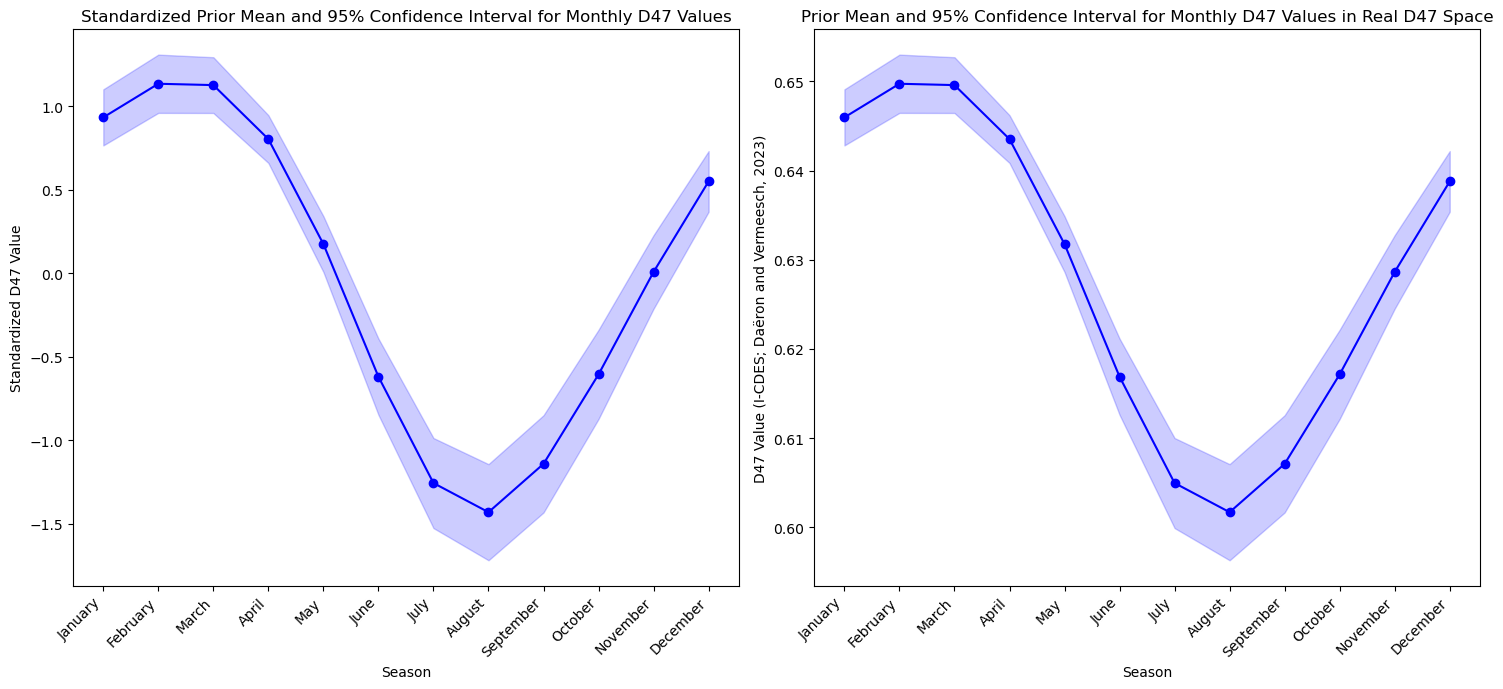

In [37]:
# Establish prior distribution based on monthly _monthly model outcomes

# Set dimensions of data
n_models_monthly = len(PlioMIP_monthly["modelname"]) # Find the total number of models (use monthly data because monthly data has this column duplicated 3 times)

# Define month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plot monthly prior distribution
# Plotting the prior mean and uncertainty
months_scale = np.arange(len(months)) + 1 # Create monthly scale

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (15, 7))

# Plot standardized prior
axes[0].plot(months_scale, mu_prior_D47_monthly, label = 'Standardized Prior D47 Mean', color = 'b', marker = 'o')
axes[0].set_title('Standardized Prior Mean and 95% Confidence Interval for Monthly D47 Values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Standardized D47 Value')

# Adding 95% confidence intervals
axes[0].fill_between(months_scale,
    mu_prior_D47_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with month names
axes[0].set_xticks(months_scale)
axes[0].set_xticklabels(month_names, rotation = 45, ha = "right")

# Plot prior in real D47 space
mu_prior_D47_monthly_real = mu_prior_D47_monthly * std_D47 + mean_D47  # Convert standardized means back to real D47 space
std_prior_D47_monthly_real = std_prior_D47_monthly * std_D47  # Convert standardized std dev back to real D47 space

axes[1].plot(months_scale, mu_prior_D47_monthly_real, label = 'Prior D47 Mean', color = 'b', marker = 'o')
axes[1].set_title('Prior Mean and 95% Confidence Interval for Monthly D47 Values in Real D47 Space')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('D47 Value (I-CDES; Daëron and Vermeesch, 2023)')

# Adding 95% confidence intervals (mean ± 1.96 * standard deviation)
axes[1].fill_between(months_scale,
    mu_prior_D47_monthly_real - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_real / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly_real + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_real / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with month names
axes[1].set_xticks(months_scale)
axes[1].set_xticklabels(month_names, rotation = 45, ha = "right")

# Show plot
plt.tight_layout()
plt.show()

## Calculate the monthly prior for model SST and SAT values

In [38]:
# Calculate the mean and standard deviation of the entire SST and SAT data
mean_SAT = PlioMIP_monthly[[f"{month}_SAT" for month in months]].stack().mean()
std_SAT = PlioMIP_monthly[[f"{month}_SAT" for month in months]].stack().std(ddof = 1)

mean_SST = PlioMIP_monthly[[f"{month}_SST" for month in months]].stack().mean()
std_SST = PlioMIP_monthly[[f"{month}_SST" for month in months]].stack().std(ddof = 1)

# Standardize the entire SST and SAT data
standardized_SAT_monthly = (PlioMIP_monthly[[f"{month}_SAT" for month in months]] - mean_SAT) / std_SAT
standardized_SST_monthly = (PlioMIP_monthly[[f"{month}_SST" for month in months]] - mean_SST) / std_SST

# Prior SST & SAT estimates from climate models (mean)
mu_prior_SAT_monthly = np.array(standardized_SAT_monthly.mean(axis = 0, skipna = True))
mu_prior_SST_monthly = np.array(standardized_SST_monthly.mean(axis = 0, skipna = True))

# Covariance between months in prior SST & SAT estimates from climate models (covariance matrix)
cov_prior_SAT_monthly = np.cov(standardized_SAT_monthly.dropna(), rowvar = False)  # Compute the covariance matrix for the standardized data (without measurement uncertainty)
cov_prior_SST_monthly = np.cov(standardized_SST_monthly.dropna(), rowvar = False)  # Compute the covariance matrix for the standardized data (without measurement uncertainty)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SAT_monthly_original, cov_prior_SAT_monthly_original = mu_prior_SAT_monthly.copy(), cov_prior_SAT_monthly.copy()
mu_prior_SST_monthly_original, cov_prior_SST_monthly_original = mu_prior_SST_monthly.copy(), cov_prior_SST_monthly.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SAT_monthly = np.sqrt(np.diag(cov_prior_SAT_monthly))
std_prior_SST_monthly = np.sqrt(np.diag(cov_prior_SST_monthly))

print(mu_prior_SAT_monthly)
print(std_prior_SAT_monthly)

[-1.10355078 -1.10703415 -0.88438879 -0.43135724  0.19119828  0.96334516
  1.45759658  1.39063847  0.8237201   0.11669288 -0.51050714 -0.90635337]
[0.36125761 0.38454606 0.35144165 0.30973673 0.32336947 0.36932468
 0.45035949 0.47580018 0.45303391 0.42942907 0.38877523 0.36304547]


## Plot the monthly prior for model SAT values

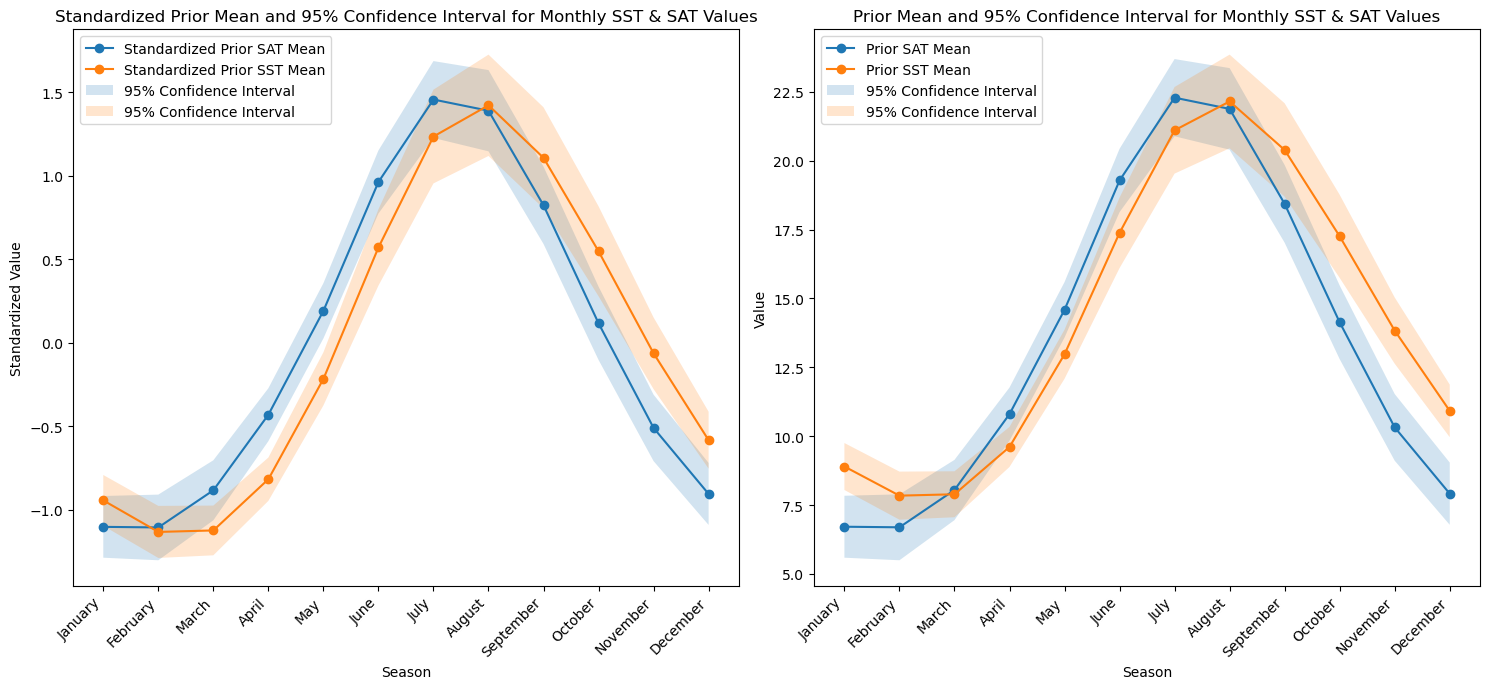

In [39]:
# Convert standardized means and standard deviations back to real space
mu_prior_SAT_monthly_real = mu_prior_SAT_monthly * std_SAT + mean_SAT
std_prior_SAT_monthly_real = std_prior_SAT_monthly * std_SAT

mu_prior_SST_monthly_real = mu_prior_SST_monthly * std_SST + mean_SST
std_prior_SST_monthly_real = std_prior_SST_monthly * std_SST

# Plot the prior distribution and confidence envelopes per season for SST & SAT
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (15, 7))

# Plot standardized SST and SAT priors
axes[0].plot(months_scale, mu_prior_SAT_monthly, label = 'Standardized Prior SAT Mean', marker = 'o')
axes[0].plot(months_scale, mu_prior_SST_monthly, label = 'Standardized Prior SST Mean', marker = 'o')
axes[0].set_title('Standardized Prior Mean and 95% Confidence Interval for Monthly SST & SAT Values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Standardized Value')

# Adding 95% confidence intervals
axes[0].fill_between(months_scale,
    mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, len(standardized_SAT_monthly)) * std_prior_SAT_monthly / np.sqrt(len(standardized_SAT_monthly)),
    mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, len(standardized_SAT_monthly)) * std_prior_SAT_monthly / np.sqrt(len(standardized_SAT_monthly)), 
    alpha = 0.2,
    label = '95% Confidence Interval'
)
axes[0].fill_between(months_scale,
    mu_prior_SST_monthly - stats.t.ppf(1 - 0.025, len(standardized_SST_monthly)) * std_prior_SST_monthly / np.sqrt(len(standardized_SST_monthly)),
    mu_prior_SST_monthly + stats.t.ppf(1 - 0.025, len(standardized_SST_monthly)) * std_prior_SST_monthly / np.sqrt(len(standardized_SST_monthly)), 
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with month names
axes[0].set_xticks(months_scale)
axes[0].set_xticklabels(month_names, rotation = 45, ha = "right")
axes[0].legend()

# Plot SST and SAT priors in real space
axes[1].plot(months_scale, mu_prior_SAT_monthly_real, label = 'Prior SAT Mean', marker = 'o')
axes[1].plot(months_scale, mu_prior_SST_monthly_real, label = 'Prior SST Mean', marker = 'o')
axes[1].set_title('Prior Mean and 95% Confidence Interval for Monthly SST & SAT Values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Value')

# Adding 95% confidence intervals (mean ± 1.96 * standard deviation)
axes[1].fill_between(months_scale,
    mu_prior_SAT_monthly_real - stats.t.ppf(1 - 0.025, len(standardized_SAT_monthly)) * std_prior_SAT_monthly_real / np.sqrt(len(standardized_SAT_monthly)),
    mu_prior_SAT_monthly_real + stats.t.ppf(1 - 0.025, len(standardized_SAT_monthly)) * std_prior_SAT_monthly_real / np.sqrt(len(standardized_SAT_monthly)), 
    alpha = 0.2,
    label = '95% Confidence Interval'
)
axes[1].fill_between(months_scale,
    mu_prior_SST_monthly_real - stats.t.ppf(1 - 0.025, len(standardized_SST_monthly)) * std_prior_SST_monthly_real / np.sqrt(len(standardized_SST_monthly)),
    mu_prior_SST_monthly_real + stats.t.ppf(1 - 0.025, len(standardized_SST_monthly)) * std_prior_SST_monthly_real / np.sqrt(len(standardized_SST_monthly)), 
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with month names
axes[1].set_xticks(months_scale)
axes[1].set_xticklabels(month_names, rotation = 45, ha = "right")
axes[1].legend()

# Show plot
plt.tight_layout()
plt.show()

## Calculate the monthly covariance matrix for standardized D47 and SAT values

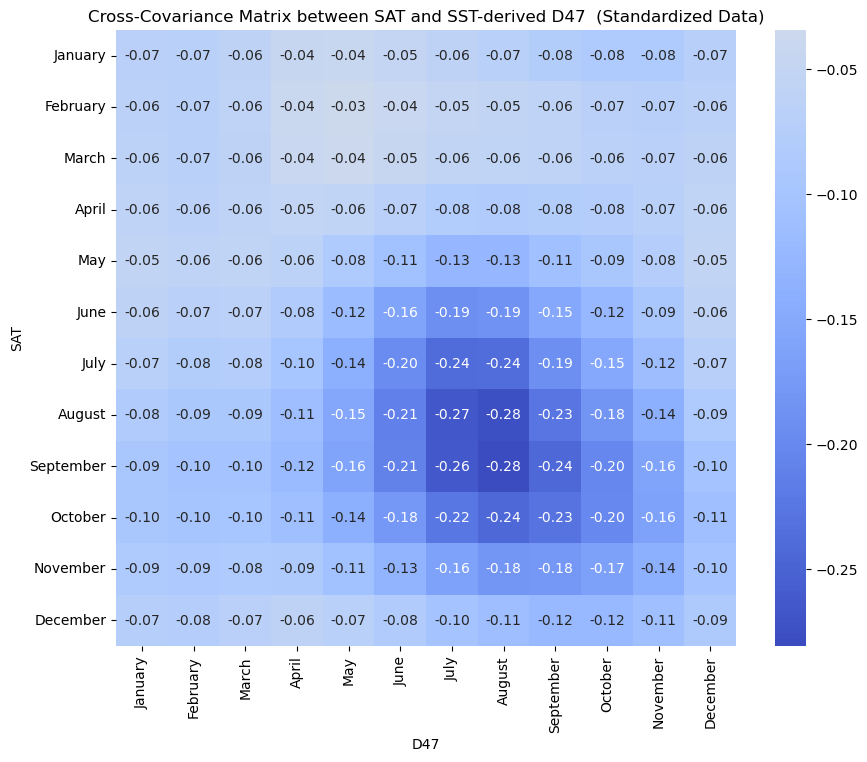

In [40]:
# Combine the standardized D47 and SAT data
combined_data_monthly = pd.concat([standardized_D47_monthly, standardized_SAT_monthly], axis = 1)

# Calculate the covariance matrix for the combined data
cov_combined_monthly_std = np.cov(combined_data_monthly.dropna(), rowvar = False)

# Extract the covariance matrices for SAT, SST, and D47
cov_SAT_monthly_std = cov_combined_monthly_std[:len(months), :len(months)]
cov_D47_monthly_std = cov_combined_monthly_std[len(months):, len(months):]

# Extract the cross-covariance matrix
cov_SAT_D47_monthly_std = cov_combined_monthly_std[:len(months), len(months):]

# Plot a heatmap of the cross-covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    cov_SAT_D47_monthly_std,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = month_names,
    yticklabels = month_names
)
plt.title("Cross-Covariance Matrix between SAT and SST-derived D47  (Standardized Data)")
plt.xlabel("D47")
plt.ylabel("SAT")
plt.show()

# PRIOR - SEASONAL

## Seasonal model data (convert the PlioMIP data to seasonal means)

In [41]:
# Define the seasons
seasons = {
    "winter": ["dc", "ja", "fb"],
    "spring": ["mr", "ar", "my"],
    "summer": ["jn", "jl", "ag"],
    "autumn": ["sp", "ot", "nv"],
}

# Stack monthly columns to create a seasonal dataframes
# Initialize dictionaries to store seasonal data
PlioMIP_seasonal_dict = {}

# Identify the columns to process (all except the modelname column)
columns_to_process = [col for col in PlioMIP_monthly.columns if any(suffix in col for suffix in ['_SST', '_SAT', '_D47', '_D47_SE'])]

# Process each season
for season, months in seasons.items(): # Iterate over the seasons and corresponding months
    for col in columns_to_process: # Iterate over the columns to process
        base_col_name = col.split('_')[0] # Extract the base column name
        suffix = '_'.join(col.split('_')[1:]) # Extract the suffix
        if base_col_name in months: # Check if the column corresponds to the current season
            season_col_name = f"{season}_{suffix}" # Create the new column name
            if season_col_name not in PlioMIP_seasonal_dict: # Check if the new column name already exists in the seasonal data
                PlioMIP_seasonal_dict[season_col_name] = [] # If not, tnitialize a new column in the seasonal data means
            PlioMIP_seasonal_dict[season_col_name].append(PlioMIP_monthly[col])

# Combine the seasonal data into a single dataframe
PlioMIP_seasonal = pd.DataFrame()
for season_col_name, data in PlioMIP_seasonal_dict.items():
    # Concatenate the data for each season and reshape it properly
    concatenated_data = pd.concat(data, axis = 0).reset_index(drop = True)
    PlioMIP_seasonal[season_col_name] = concatenated_data

# Add model names
PlioMIP_seasonal["modelname"] = np.tile(PlioMIP_monthly["modelname"].values, 3) # Repeat the model names for each season

# Display the new seasonal DataFrame
PlioMIP_seasonal.head()
# print("Seasonal values for all model outcomes:\n", PlioMIP_seasonal.head())

,winter_SST,winter_SAT,winter_D47,winter_D47_SE,spring_SST,spring_SAT,spring_D47,spring_D47_SE,summer_SST,summer_SAT,summer_D47,summer_D47_SE,autumn_SST,autumn_SAT,autumn_D47,autumn_D47_SE,modelname
0,NaN,8.39,NaN,NaN,NaN,9.63,NaN,NaN,NaN,19.61,NaN,NaN,NaN,19.02,NaN,NaN,CCSM4
1,8.33,6.97,0.648316,0.001328,7.45,9.96,0.651496,0.001353,18.40,21.92,0.613992,0.001119,22.60,19.69,0.600724,0.001072,CCSM4-UoT
2,9.96,9.43,0.642505,0.001284,8.95,10.88,0.646093,0.001311,19.37,21.09,0.610876,0.001106,23.95,21.79,0.596581,0.001062,CCSM4-Utr
3,NaN,9.32,NaN,NaN,NaN,10.56,NaN,NaN,NaN,20.91,NaN,NaN,NaN,20.11,NaN,NaN,CESM1.2
4,NaN,10.70,NaN,NaN,NaN,11.75,NaN,NaN,NaN,22.31,NaN,NaN,NaN,21.79,NaN,NaN,CESM2


## Calculate the seasonal prior for model SST-derived D47 values with propagated uncertainty

In [42]:
# Create list of season names
seasons = ["winter", "spring", "summer", "autumn"]

# Standardize the entire D47 data
standardized_D47_seasonal = (PlioMIP_seasonal[[f"{season}_D47" for season in seasons]] - mean_D47) / std_D47

# Set the weights of the data based on the standard errors
weights_seasonal = 1 / PlioMIP_seasonal[[f"{season}_D47_SE" for season in seasons]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_seasonal to match the headers of the D47 matrix later for multiplication
weights_seasonal.columns = [col.replace('_D47_SE', '_D47') for col in weights_seasonal.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_D47_seasonal = np.array((standardized_D47_seasonal * weights_seasonal).sum(axis = 0, skipna = True) / weights_seasonal.sum(axis = 0, skipna = True))  # Calculate weighted seasonly mean D47 values and convert to numpy array

# Standardize the measurement variances
measurement_variances = ((PlioMIP_seasonal[[f"{season}_D47_SE" for season in seasons]] ** 2).mean(axis = 0, skipna = True))  # Compute variance on measurements in D47 space
model_variances = np.diag(np.cov(PlioMIP_seasonal[[f"{season}_D47" for season in seasons]].dropna(), rowvar = False))  # Extract the diagonal terms of the covariance matrix (variances of the models) in D47 space

# Covariance between seasons in prior D47 estimates from climate models (weighted covariance matrix)
cov_prior_D47_seasonal = np.cov(standardized_D47_seasonal.dropna(), rowvar = False)  # Compute the covariance matrix for the standardized data (without measurement uncertainty)
combined_variances = model_variances + measurement_variances  # Add the measurement variances to the model variances
np.fill_diagonal(cov_prior_D47_seasonal, combined_variances / std_D47 ** 2)  # Add diagonal terms for measurement uncertainties (which have no covariance between models) and standardize

# Store copy of original prior means to keep when later updating the prior
mu_prior_D47_seasonal_original, cov_prior_D47_seasonal_original = mu_prior_D47_seasonal.copy(), cov_prior_D47_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_D47_seasonal = np.sqrt(np.diag(cov_prior_D47_seasonal))

print(mu_prior_D47_seasonal)
print(std_prior_D47_seasonal)

[ 0.86115898  0.67000875 -1.11640296 -0.61190123]
[0.41248396 0.50274398 0.61013709 0.68476674]


## Plot the seasonal prior for model SST-derived D47 values with propagated uncertainty

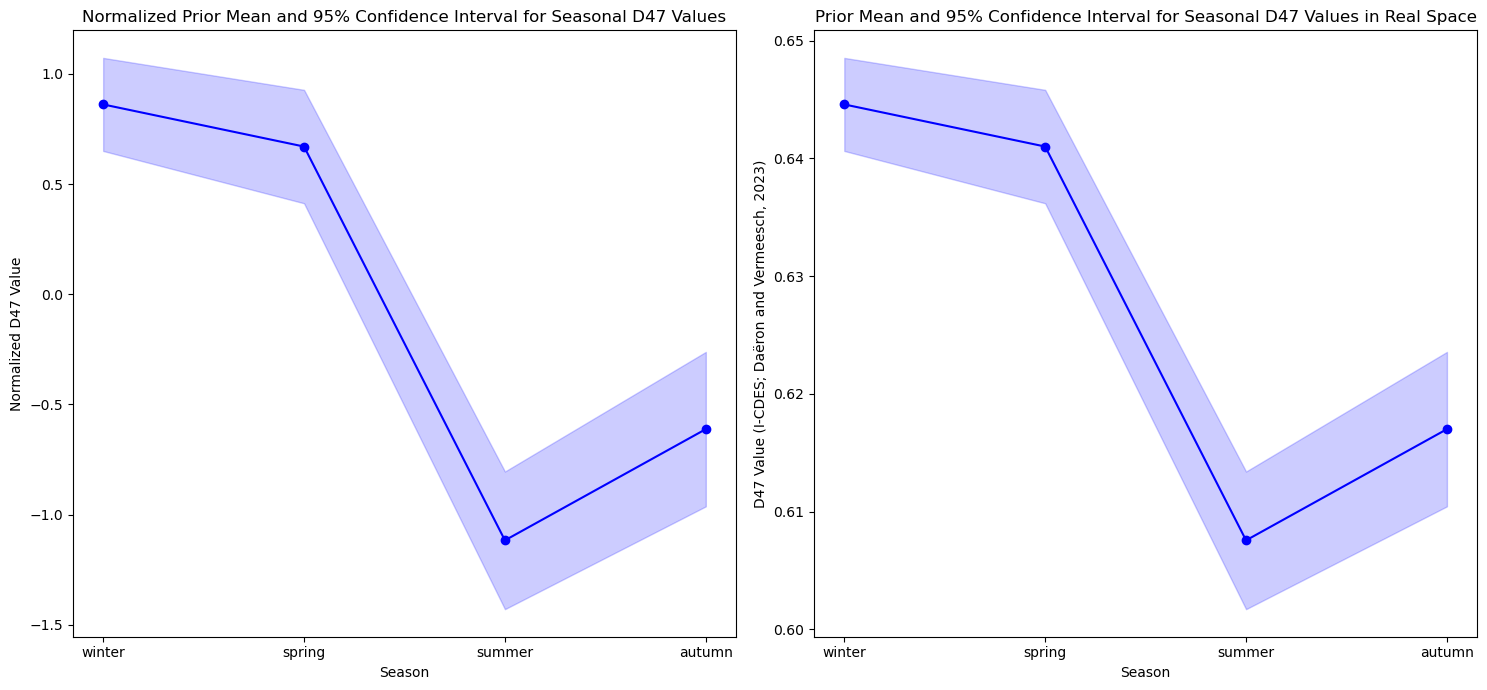

In [43]:
# Establish prior distribution based on seasonal PlioMIP model outcomes

# Set dimensions of data
n_models_seasonal = len(PlioMIP_monthly["modelname"])  # Find the total number of models (use monthly data because seasonal data has this column duplicated 3 times)

# Plot seasonal prior distribution
# Plotting the prior mean and uncertainty
seasons_scale = np.arange(len(seasons)) + 1  # Create seasonal scale

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (15, 7))

# Plot normalized priors
axes[0].plot(seasons_scale, mu_prior_D47_seasonal, label = 'Normalized Prior D47 Mean', color = 'b', marker = 'o')
axes[0].set_title('Normalized Prior Mean and 95% Confidence Interval for Seasonal D47 Values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Normalized D47 Value')

# Adding 95% confidence intervals (mean ± 1.96 * standard deviation)
axes[0].fill_between(seasons_scale,
    mu_prior_D47_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with season names
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)

# Plot regular D47-scale priors
mu_prior_D47_seasonal_real = mu_prior_D47_seasonal * std_D47 + mean_D47  # Convert normalized means back to real D47 space
std_prior_D47_seasonal_real = std_prior_D47_seasonal * std_D47  # Convert normalized std dev back to real D47 space

axes[1].plot(seasons_scale, mu_prior_D47_seasonal_real, label = 'Prior D47 Mean', color = 'b', marker = 'o')
axes[1].set_title('Prior Mean and 95% Confidence Interval for Seasonal D47 Values in Real Space')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('D47 Value (I-CDES; Daëron and Vermeesch, 2023)')

# Adding 95% confidence intervals (mean ± 1.96 * standard deviation)
axes[1].fill_between(seasons_scale,
    mu_prior_D47_seasonal_real - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_real / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_real + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_real / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with season names
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)

# Show plot
plt.tight_layout()
plt.show()

## Calculate the seasonal prior for model SAT values

In [45]:
# Standardize the entire SST and SAT data
standardized_SAT_seasonal = (PlioMIP_seasonal[[f"{season}_SAT" for season in seasons]] - mean_SAT) / std_SAT
standardized_SST_seasonal = (PlioMIP_seasonal[[f"{season}_SST" for season in seasons]] - mean_SST) / std_SST

# Prior SST & SAT estimates from climate models (mean)
mu_prior_SAT_seasonal = np.array(standardized_SAT_seasonal.mean(axis = 0, skipna = True))
mu_prior_SST_seasonal = np.array(standardized_SST_seasonal.mean(axis = 0, skipna = True))

# Covariance between seasons in prior SST & SAT estimates from climate models (covariance matrix)
cov_prior_SAT_seasonal = np.cov(standardized_SAT_seasonal.dropna(), rowvar = False)  # Compute the covariance matrix for the standardized data (without measurement uncertainty)
cov_prior_SST_seasonal = np.cov(standardized_SST_seasonal.dropna(), rowvar = False)  # Compute the covariance matrix for the standardized data (without measurement uncertainty)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SAT_seasonal_original, cov_prior_SAT_seasonal_original = mu_prior_SAT_seasonal.copy(), cov_prior_SAT_seasonal.copy()
mu_prior_SST_seasonal_original, cov_prior_SST_seasonal_original = mu_prior_SST_seasonal.copy(), cov_prior_SST_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SAT_seasonal = np.sqrt(np.diag(cov_prior_SAT_seasonal))
std_prior_SST_seasonal = np.sqrt(np.diag(cov_prior_SST_seasonal))

print(mu_prior_SAT_seasonal)
print(std_prior_SAT_seasonal)

[-1.03897943 -0.37484925  1.27052674  0.14330195]
[0.37447552 0.54953114 0.47945939 0.68995882]


## Plot the seasonal prior for model SAT values

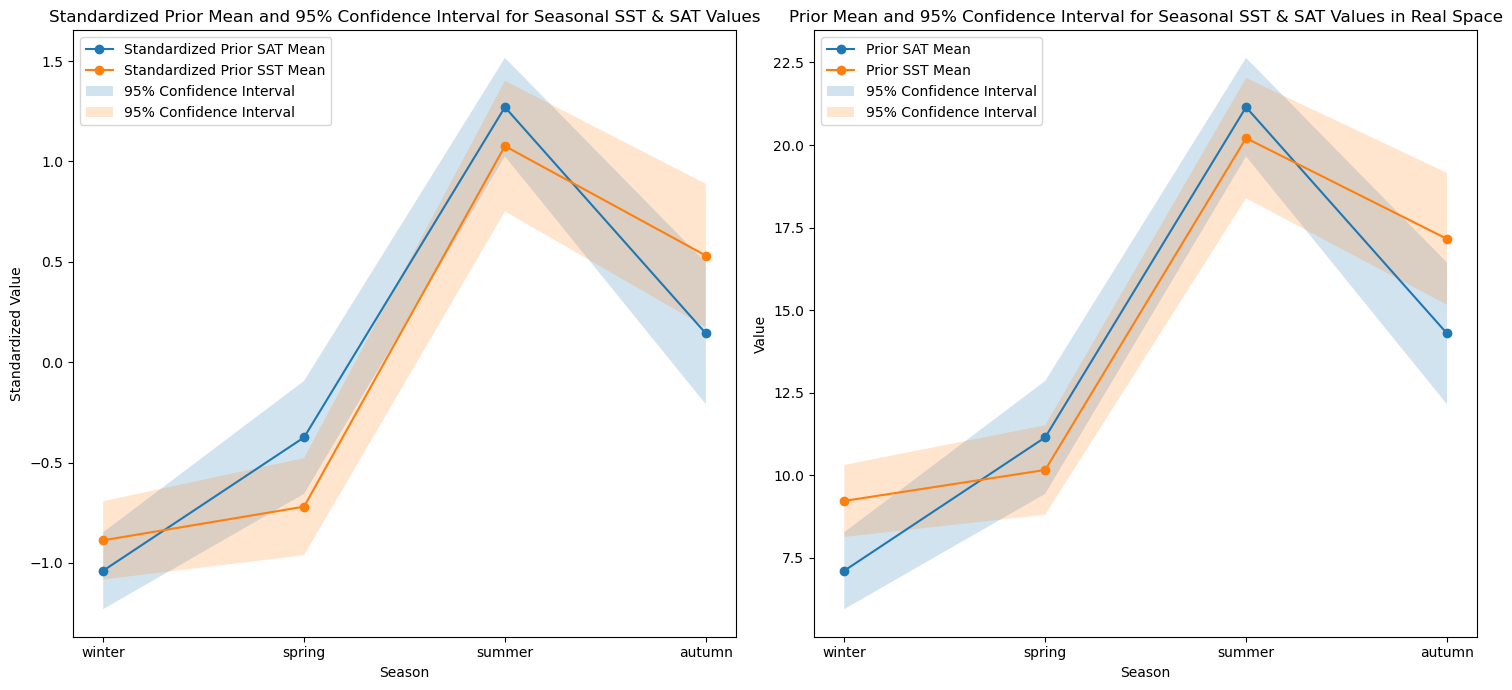

In [46]:

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (15, 7))

# Plot standardized priors for SST and SAT
axes[0].plot(seasons_scale, mu_prior_SAT_seasonal, label = 'Standardized Prior SAT Mean', marker = 'o')
axes[0].plot(seasons_scale, mu_prior_SST_seasonal, label = 'Standardized Prior SST Mean', marker = 'o')
axes[0].set_title('Standardized Prior Mean and 95% Confidence Interval for Seasonal SST & SAT Values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Standardized Value')

# Adding 95% confidence intervals
axes[0].fill_between(seasons_scale,
    mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal), 
    alpha = 0.2,
    label = '95% Confidence Interval'
)
axes[0].fill_between(seasons_scale,
    mu_prior_SST_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SST_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal), 
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with season names
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].legend()

# Plot priors in original unit for SST and SAT
mu_prior_SAT_seasonal_real = mu_prior_SAT_seasonal * std_SAT + mean_SAT  # Convert standardized means back to real SAT space
std_prior_SAT_seasonal_real = std_prior_SAT_seasonal * std_SAT  # Convert standardized std dev back to real SAT space

mu_prior_SST_seasonal_real = mu_prior_SST_seasonal * std_SST + mean_SST  # Convert standardized means back to real SST space
std_prior_SST_seasonal_real = std_prior_SST_seasonal * std_SST  # Convert standardized std dev back to real SST space

axes[1].plot(seasons_scale, mu_prior_SAT_seasonal_real, label = 'Prior SAT Mean', marker = 'o')
axes[1].plot(seasons_scale, mu_prior_SST_seasonal_real, label = 'Prior SST Mean', marker = 'o')
axes[1].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST & SAT Values in Real Space')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Value')

# Adding 95% confidence intervals
axes[1].fill_between(seasons_scale,
    mu_prior_SAT_seasonal_real - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal_real / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal_real + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal_real / np.sqrt(n_models_seasonal), 
    alpha = 0.2,
    label = '95% Confidence Interval'
)
axes[1].fill_between(seasons_scale,
    mu_prior_SST_seasonal_real - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal_real / np.sqrt(n_models_seasonal),
    mu_prior_SST_seasonal_real + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal_real / np.sqrt(n_models_seasonal), 
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with season names
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].legend()

# Show plot
plt.tight_layout()
plt.show()

## Calculate the seasonal covariance matrix for standardized D47 and SAT values

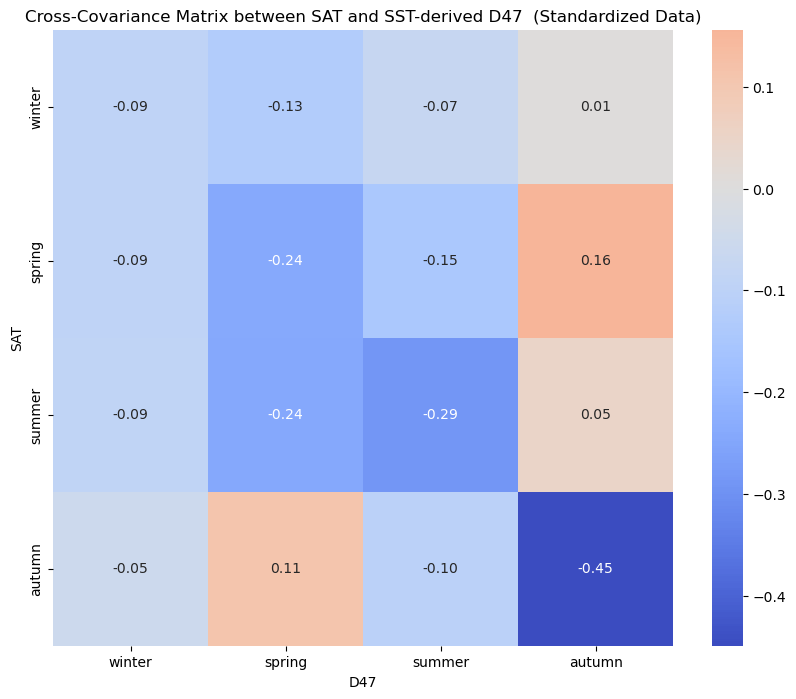

In [49]:
# Combine the standardized D47 and SAT data
combined_data_seasonal = pd.concat([standardized_D47_seasonal, standardized_SAT_seasonal], axis = 1)

# Calculate the covariance matrix for the combined data
cov_combined_seasonal_std = np.cov(combined_data_seasonal.dropna(), rowvar = False)

# Extract the covariance matrices for SAT, SST, and D47
cov_SAT_seasonal_std = cov_combined_seasonal_std[:len(seasons), :len(seasons)]
cov_D47_seasonal_std = cov_combined_seasonal_std[len(seasons):, len(seasons):]

# Extract the cross-covariance matrix
cov_SAT_D47_seasonal_std = cov_combined_seasonal_std[:len(seasons), len(seasons):]

# Plot a heatmap of the cross-covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    cov_SAT_D47_seasonal_std,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = seasons,
    yticklabels = seasons
)
plt.title("Cross-Covariance Matrix between SAT and SST-derived D47  (Standardized Data)")
plt.xlabel("D47")
plt.ylabel("SAT")
plt.show()

# UPDATE
## Load clumped data for updating
### Seasonal data from PWP paper

In [ ]:
# FIXME: Isolate data for updating into a dataframe for offline matrix-wise updating instead of looping through the dictionary

# Load seasonal measurements and format them into a dictionary
# This is precompiled seasonal data per specimen and therefore does not come with a time uncertainty
PWP_D47_seasonal = pd.read_csv('PWP case/PWP_proxy_data_seasonal.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PWP_D47_seasonal_dict = PWP_D47_seasonal.to_dict('records') # Convert to dictionary with column headers as keys

# Add an entry for the time uncertainty (which is always zero in this case, because data is already aggregated seasonally)
for record in PWP_D47_seasonal_dict:
    record["Season_err"] = 0
    record["D47_std"] = (record["D47"] - mean_D47) / std_D47 # Add standardized D47 values to the dictionary
    record["D47_sd_std"] = record["D47_sd"] / std_D47 # Add standardized D47 SE values to the dictionary

print(PWP_D47_seasonal_dict[0]) # Print to check the structure of the data

{'season_score': 4, 'd13C': 1.163185755, 'd13C.lower': 0.779157572, 'd13C.upper': 1.354243212, 'd13C_sd': 0.287845755, 'd18O': 2.290168712, 'd18O.lower': 2.121157663, 'd18O.upper': 2.48333174, 'd18O_sd': 0.181277819, 'D47': 0.610081855, 'D47.lower': 0.594175238, 'D47.upper': 0.61649739, 'D47_sd': 0.011172835, 'T_mean': 21.42, 'temp.lower': 19.15042268, 'temp.upper': 26.9231683, 'T_sd': 3.890467215, 'd18Ow': 2.770476926, 'd18Ow.lower': 2.212932741, 'd18Ow.upper': 3.911848228, 'd18Ow_sd': 0.850352672, 'Specimen': 'SG105', 'Species': 'Pygocardia rustica', 'N': 6, 'method': 'strict', 'season2': 'summer', 'season': 2, 'Season_err': 0, 'D47_std': -0.9816538547466711, 'D47_sd_std': 0.5966901799949396}


### Monthly and seasonal data calculated from ShellChron outcomes

In [55]:
# Load measurements and format them into a dictionary
# These are the actual individual D47 measurements and ShellChron outcomes and thus come with a time uncertainty which can be propagated.
PWP_D47 = pd.read_csv('PWP case/PWP_proxy_data_months.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PWP_D47_dict = PWP_D47.to_dict('records') # Convert to dictionary with column headers as keys

# Process the ShellChron_DOY_err field and create a new entry for months
for record in PWP_D47_dict:
    # Handle missing values and convert from days to months and seasons
    shell_chron_doy_err = record.get("ShellChron_DOY_err", np.nan)  # Get value, default to NaN if missing
    if pd.isna(shell_chron_doy_err):  # Check if the value is NaN
        record["ShellChron_Month_err"] = 0  # Set the new entry to 0 if missing
        record["ShellChron_Season_err"] = 0  # Set the new entry to 0 if missing
    else:
        record["ShellChron_Month_err"] = shell_chron_doy_err / 365 * 12  # Convert days to months
        record["ShellChron_Season_err"] = shell_chron_doy_err / 365 * 4  # Convert days to seasons
    
    # Add the month_score2 and season_score field based on the ShellChron_DOY field
    ShellChron_DOY = record.get("ShellChron_DOY_rotated", np.nan)  # Get the ShellChron day of the year value
    if not pd.isna(ShellChron_DOY):  # Check if the ShellChron value is not NaN
        record["month_score2"] = ShellChron_DOY / 365 * 12  # Convert DOY value to month_score
        record["season_score"] = ShellChron_DOY / 365 * 4  # Convert DOY value to season_score

    record["D47_std"] = (record["D47_corrETF_strict"] - mean_D47) / std_D47 # Add standardized D47 values to the dictionary
    record["D47_sd_std"] = record["D47_sd_ext"] / std_D47 # Add standardized D47 SE values to the dictionary

print(PWP_D47_dict[0]) # Print to check the structure of the data

{'Date': 44672.55972, 'Sample_name': 'Pygocardia A2', 'Run': 234, 'ID': 'BG', 'Row': 5, 'Int': 18203.792, 'par49': 0.000541427, 'd47': 18.43919802, 'd47_SE': 0.019680173, 'D47_Raw': -0.229883662, 'D47_SD': 0.117771893, 'D47_final': 0.6237, 'Final_d18O': 2.239117264, 'Final_d13C': -0.397061707, 'OUTLIER': False, 'Specimen': 'SG105', 'Species': 'Pygocardia rustica', 'Sample_nr': '2', 'Datetime': 44672.55972, 'Sample_or_Standard': 'Sample', 'Sample_or_Standard2': 'Sample', 'D47_offset_corr_strict': 0.630410712, 'D47_offset_N_strict': '40', 'D47_accepted': nan, 'D47_corrETF_strict': 0.621082944, 'D47_acc': nan, 'Instrument': 'PACMAN', 'D47_sd_ext': 0.049933999, 'd18O_sd_ext': 0.092848257, 'd13C_sd_ext': 0.141236548, 'mineral': 'aragonite', 'temp_strict': 17.70589374, 'd18Ow_strict': 3.123629307, 'Sample_nr2': 2.0, 'Dist': 61.7160274, 'ShellChron_Age': 2579.385569, 'ShellChron_DOY': 24.38556935, 'ShellChron_DOY_err': nan, 'month_score': 1, 'month': 'January', 'Day_offset': 1, 'ShellChron_DO

## Create updating function (Kalman filter)
### Include updating of second variable (SAT) through cross-covariance

In [ ]:
# FIXME: Add/update function to enable offline updates of the prior estimates instead of looping through a dictionary

# Create Kalman updating function
def kalman_update(
    mu_prior,
    cov_prior,
    measurement,
    timestamp,
    timestamp_sd,
    Variable_name = "D47",
    Variable_name_SD = "D47_sd",
    cross_cov = None,
    mu_prior_SAT = None,
    cov_prior_SAT = None,
):
    """
Update the prior state with a measurement, including uncertainty in the time domain.

Parameters:
- mu_prior: np.ndarray
    Prior means for all bins for the measured variable (usually D47).
- cov_prior: np.ndarray
    Covariance matrix for the prior state of the measured variable (usually D47).
- measurement: dict
    Dictionary containing the observation, its SD, and a timestamp value with its SD.
- timestamp: str
    Key in the measurement dictionary for the timestamp (0-based index).
- timestamp_sd: float
    Standard deviation of uncertainty in the timestamp (in units of timestamp).
- Variable_name: str
    Key in the measurement dictionary for the data.
- Variable_name_SD: str
    Key in the measurement dictionary for the standard deviation on the data.
- cross_cov: np.ndarray, optional
    Cross-covariance matrix between the measured variable (D47) and a second (unmeasured) variable (SAT).
- mu_prior_SAT: np.ndarray, optional
    Prior means for a second (unmeasured) variable (SAT).
- cov_prior_SAT: np.ndarray, optional
    Covariance matrix for a second (unmeasured) variable (SAT).

Returns:
- mu_prior: np.ndarray
    Updated means after applying the measurement.
- cov_prior: np.ndarray
    Updated covariance matrix after applying the measurement.
- mu_prior_SAT: np.ndarray, optional
    Updated means for SAT after applying the measurement.
- cov_prior_SAT: np.ndarray, optional
    Updated covariance matrix for SAT after applying the measurement.
"""
    print(mu_prior_SAT) # Print the updated SAT estimates to check
    print(np.diag(cov_prior_SAT)) # Print the updated SAT covariance matrix to check

    try: # Catch errors in individual entries without breaking the loop
        time = measurement[timestamp]
        time_sd = measurement[timestamp_sd]
        obs_variable = measurement[Variable_name]
        obs_var = measurement[Variable_name_SD] ** 2

        if not np.isnan(time) and not np.isnan(obs_variable) and not np.isnan(obs_var): # Check if the observation is not NaN
            if time_sd == 0 or np.isnan(time_sd): # If there is no uncertainty in the timestamp
                # Direct update without using weights (standard Kalman update)

                # Prior mean and variance for the specific time
                mu_prior_time = mu_prior[int(time)]
                cov_prior_time = cov_prior[int(time), int(time)]
                
                # Kalman gain
                K = cov_prior_time / (cov_prior_time + obs_var)

                # Update mean and variance
                mu_post_time = mu_prior_time + K * (obs_variable - mu_prior_time)
                cov_post_time = (1 - K) * cov_prior_time
                
                # Update the prior arrays with the new posterior values to create posteriors
                mu_post = mu_prior.copy()
                cov_post = cov_prior.copy()
                mu_post[int(time)] = mu_post_time
                cov_post[int(time), int(time)] = cov_post_time

                # Check if cross-covariance and SAT estimates are provided
                if cross_cov is not None and mu_prior_SAT is not None and cov_prior_SAT is not None:
                    # Update SAT estimates using cross-covariance
                    cross_cov_time = cross_cov[int(time), :] # Extract the cross-covariance for the given time unit
                    K_SAT = cross_cov_time / (cov_prior_time + obs_var) # Calculate the Kalman gain for the second variable (SAT)
                    mu_post_SAT = mu_prior_SAT + K_SAT * (obs_variable - mu_prior_time) # Update the mean for the second variable (SAT)
                    cov_post_SAT = cov_prior_SAT - np.outer(K_SAT, cross_cov_time) # Update the covariance for the second variable (SAT)

                    return mu_post, cov_post, mu_post_SAT, cov_post_SAT # Return updated values for both variables
                                
            else: # If there is uncertainty in the timestamp
                # Define possible bins and weights based on normal uncertainty on the age of the measurement
                n_bins = len(mu_prior)
                time_indices = np.arange(n_bins)
                weights = stats.norm.pdf(time_indices, loc = time, scale = time_sd)
                weights = weights / weights.sum()  # Normalize weights

                # Weighted observation and variance
                weighted_obs = np.sum(weights * mu_prior) # calculate the weighted prior mean
                weighted_var = obs_var + np.sum(weights ** 2 * np.diag(cov_prior)) # calculate a weighted variance with respect to the uncertainty distribution of the time of the measurement

                # Kalman gain weighted by the uncertainty on the age determination
                K = np.dot(cov_prior, weights) / (np.dot(weights, np.dot(cov_prior, weights)) + weighted_var)

                # Update mean values
                mu_post = mu_prior + K * (obs_variable - weighted_obs)

                # Update covariance matrix

                ## FIXME: Sometimes results in negative variance, which is not possible!!
                ## Potential solution: Overwrite diagonal elements with the weighted variances?

                # # Update covariance matrix using Joseph form to ensure positive semi-definite matrix
                # I = np.eye(n_bins) # Identity matrix
                # KH = np.outer(K, weights) # Product of Kalman gain and weights
                # cov_post = np.dot(np.dot((I - KH), cov_prior), (I - KH).T) + np.outer(K, K) * weighted_var
                
                cov_post = cov_prior - np.outer(K, np.dot(weights, cov_prior)) # Simplified form without Joseph form

                # Check if cross-covariance and SAT estimates are provided
                if cross_cov is not None and mu_prior_SAT is not None and cov_prior_SAT is not None:
                    # Update SAT estimates using cross-covariance
                    cross_cov_weighted = np.dot(cross_cov, weights) # Calculate the weighted cross-covariance between the two variables
                    K_SAT = cross_cov_weighted / (np.dot(weights, np.dot(cov_prior, weights)) + weighted_var) # Calculate the Kalman gain for the second variable (SAT) by dividing the weighted cross-covariance by the weighted variance on the measured variable
                    mu_post_SAT = mu_prior_SAT + K_SAT * (obs_variable - weighted_obs) # Update the mean for the second variable (SAT)
                    cov_post_SAT = cov_prior_SAT - np.outer(K_SAT, cross_cov_weighted) # Update the covariance for the second variable (SAT)

                    return mu_post, cov_post, mu_post_SAT, cov_post_SAT
                
            return mu_post, cov_post # Return updated values for the measured variable only
        
        else: # If observation is NaN
            if cross_cov is not None and mu_prior_SAT is not None and cov_prior_SAT is not None: # Check if cross-covariance and SAT estimates are provided
                return mu_prior, cov_prior, mu_prior_SAT, cov_prior_SAT # Return unmodified values for both variables
            else: # If cross-covariance and SAT estimates are not provided
                return mu_prior, cov_prior  # Return unmodified values  
        
    except (KeyError, TypeError, ValueError) as e: # Return errors if they occur
        print(f"Error in kalman_update: {e}")
        if cross_cov is not None and mu_prior_SAT is not None and cov_prior_SAT is not None: # Check if cross-covariance and SAT estimates are provided
            return mu_prior, cov_prior, mu_prior_SAT, cov_prior_SAT  # Return the unmodified values for both variables even on error
        else: # If cross-covariance and SAT estimates are not provided
            return mu_prior, cov_prior  # Return the unmodified values even on error to prevent errors during the looping later

## Create function to track the statistics of the likelihood (combining just the reconstruction data)

In [57]:
# Create function to keep track of the likelihood statistics and data

# Suppress FutureWarning
warnings.simplefilter(action = 'ignore', category = FutureWarning)

def likelihood_statistics(
    weighted_sum,
    effective_weights_total,
    n_update,
    data_library,
    measurement,
    timestamp,
    timestamp_sd,
    Variable_name = "Variable_name",
    Variable_name_SD = "Variable_name_SD"
):
    """
    Incrementally updates the likelihood statistics for seasonal data.

    Parameters:
    - weighted_sum: list
        List tracking the mean times the effective weight for each time bin.
    - effective_weights_total: list
        List tracking the sum of effective weights for each time bin.
    - n_update: list
        List tracking the number of datapoints for each time bin.
    - data_library: dict
        Dictionary tracking individual data points and their uncertainties.
    - measurement: dict
        A single measurement containing seasonal and temperature data.
    - timestamp: str
        Key in the measurement dictionary for the timestamp (0-based index).
    - timestamp_sd: float
        Standard deviation of uncertainty in the timestamp.
    - Variable_name: str
        Key in the measurement dictionary for the time bin (e.g. month or season).
    - Variable_name_SD: str
        Key in the measurement dictionary for the standard deviation on the age model (e.g. month or season).
    """
    if timestamp in measurement and Variable_name in measurement and Variable_name_SD in measurement:
        time = measurement[timestamp]
        time_sd = measurement[timestamp_sd]
        data_val = measurement[Variable_name]
        data_sd = measurement[Variable_name_SD]
        
        # print(time, time_sd, data_val, data_sd) # Print to check the values

        # Check if the data is valid
        if not np.isnan(data_val) and not np.isnan(data_sd):
            # Calculate the weight (inverse of variance)
            weight = 1 / (data_sd ** 2)
                        
            # Determine the number of bins
            num_bins = len(weighted_sum)
            bin_indices = np.arange(num_bins, dtype = np.float64)
            
            # Calculate the probability density for each bin
            if time_sd == 0: # Catch cases where the time uncertainty is zero (or unknown)
                probabilities = np.zeros(num_bins, dtype = np.float64)
                bin_index = int(time) % num_bins  # Ensure the bin index is within range
                probabilities[bin_index] = 1 # Set the probability to 1 for the correct bin
            else:
                probabilities = stats.norm.pdf(bin_indices, loc = time, scale = time_sd) # For non-zero time uncertainty, use a normal distribution
                probabilities /= probabilities.sum()  # Normalize to ensure the sum of probabilities is 1
            
            for i, prob in enumerate(probabilities): # Loop over all possible bin numbers in the probability vector
                bin_index = i % num_bins  # Wrap around to the first bin if it overflows
                
                # Update the weighted sums and sample count
                effective_weight = weight * prob
                if weighted_sum[bin_index] is None:
                    weighted_sum[bin_index] = 0
                    effective_weights_total[bin_index] = 0
                weighted_sum[bin_index] = weighted_sum[bin_index] + data_val * effective_weight
                effective_weights_total[bin_index] = effective_weights_total[bin_index] + effective_weight
            
            n_update[int(time) % num_bins] = n_update[int(time) % num_bins] + 1 # update sample number per bin

            # Track individual data points and their uncertainties
            if time not in data_library:
                data_library[int(time)] = []  # Initialize the list for a new time bin
            data_library[int(time)].append((time_sd, data_val, data_sd))
    
    return weighted_sum, effective_weights_total, n_update, data_library # Return the updated values

# LEFT HERE




## Update seasonal prior with data in the standardized domain (no sclero-dating uncertainty)

In [62]:
# FIXME: This function is not working as intended and needs to be debugged
# Apply new function to update the prior with seasonal data including updating the SAT estimates
# Update the seasonal D47 and SAT prior with all measurements
seasonal_data = {} # Keep track of datapoints per season
n_update_seasonal = mu_prior_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonal = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonal = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonal = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonal = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Reset the prior to the original values
mu_prior_D47_seasonal, cov_prior_seasonal, mu_prior_SAT_seasonal, cov_prior_SAT_seasonal = mu_prior_D47_seasonal_original.copy(), cov_prior_D47_seasonal_original.copy(), mu_prior_SAT_seasonal_original.copy(), cov_prior_SAT_seasonal_original.copy()

for measurement in PWP_D47_seasonal_dict: # Loop over measurements
    # print(measurement) # Print to check the values
    # This aggregates the data to update the prior to the posterior
    mu_prior_D47_seasonal, cov_prior_seasonal, mu_prior_SAT_seasonal, cov_prior_SAT_seasonal = kalman_update(
        mu_prior_D47_seasonal,
        cov_prior_D47_seasonal,
        measurement,
        timestamp = "season",
        timestamp_sd = "Season_err",
        Variable_name = "D47_std",
        Variable_name_SD = "D47_sd_std",
        cross_cov = cov_SAT_D47_seasonal_std,
        mu_prior_SAT = mu_prior_SAT_seasonal,
        cov_prior_SAT = cov_prior_SAT_seasonal
    )
    
    # Track and update likelihood statistics
    weighted_sum_seasonal, effective_weights_total_seasonal, n_update_seasonal, seasonal_data = likelihood_statistics(
        weighted_sum_seasonal,
        effective_weights_total_seasonal,
        n_update_seasonal,
        seasonal_data,
        measurement,
        timestamp = "season",
        timestamp_sd = "Season_err",
        Variable_name = "D47_std",
        Variable_name_SD = "D47_sd_std"
    )

# Normalize the weighted_sum_seasonal to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonal to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonal)):
    if effective_weights_total_seasonal[i] is not None and effective_weights_total_seasonal[i] != 0:
        mu_likelihood_seasonal[i] = weighted_sum_seasonal[i] / effective_weights_total_seasonal[i]
        std_likelihood_seasonal[i] = np.sqrt(1 / effective_weights_total_seasonal[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonal[i] * std_D47 + mean_D47}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonal[i] * std_SST}")
    print(f"Number of Data Points: {n_update_seasonal[i]}\n")

# Print original and updated prior means and uncertainties in D47 and SAT space
print("Original Prior Mean D47 Seasonal:\n", mu_prior_D47_seasonal_original * std_D47 + mean_D47)
print("Updated Prior Mean D47 Seasonal:\n", mu_prior_D47_seasonal * std_D47 + mean_D47)
print("Original Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_D47_seasonal_original)) * std_D47)
print("Updated Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_seasonal)) * std_D47)
print("Original Prior Mean SAT Seasonal:\n", mu_prior_SAT_seasonal_original * std_SAT + mean_SAT)
print("Updated Prior Mean SAT Seasonal:\n", mu_prior_SAT_seasonal * std_SAT + mean_SAT)
print("Original Prior Standard Deviation SAT Seasonal:\n", np.sqrt(np.diag(cov_prior_SAT_seasonal_original)) * std_SAT)
print("Updated Prior Variance SAT Seasonal:\n", (np.diag(cov_prior_SAT_seasonal)) * std_SAT)

[-1.03897943 -0.37484925  1.27052674  0.14330195]
[0.14023191 0.30198447 0.2298813  0.47604317]
[-1.05598258 -0.41987002  1.2167836   0.15250036]
[0.12863557 0.22068491 0.11402802 0.47264936]
[-1.04231702 -0.38458882  1.23817297  0.12950348]
[0.12215667 0.17749997 0.09815567 0.45430159]
[-1.11763913 -0.49003202  1.17992483  0.134894  ]
[0.11422553 0.16195721 0.09341264 0.45426097]
[-1.20347303 -0.30906331  1.0124944  -0.59866003]
[0.11146138 0.14967009 0.08289516 0.25237444]
[-1.40278273 -0.58807636  0.85836409 -0.58439619]
[0.0739644  0.07618681 0.06047103 0.25218239]
[-1.42519879 -0.64594924  0.82327843 -0.54667369]
[0.06455236 0.01345103 0.03741288 0.22552815]
[-1.4188232  -0.62906802  0.84343022 -0.55012277]
[ 0.05135582 -0.07906714 -0.09442712  0.22166602]
[-1.43367999 -0.59774456  0.81445007 -0.67709197]
[ 0.04667512 -0.09987371 -0.11223705 -0.12020139]
[-1.44228433 -0.57960353  0.79766618 -0.75062636]
[ 0.04564457 -0.10445469 -0.11615826 -0.19547029]
[-1.44587845 -0.5888827   0.

## Update monthly prior with data including sclero-dating uncertainty

In [ ]:
# Update the monthly prior with all measurements
monthly_data = {} # Keep track of datapoints per season
n_update_monthly = mu_prior_D47_monthly * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthly = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthly = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthly = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthly = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Reset the prior to the original values
mu_prior_D47_monthly, cov_prior_D47_monthly, mu_prior_SAT_monthly, cov_prior_SAT_monthly = mu_prior_D47_monthly_original.copy(), cov_prior_D47_monthly_original.copy(), mu_prior_SAT_monthly_original.copy(), cov_prior_SAT_monthly_original.copy()

for measurement in PWP_D47_dict: # Loop over measurements
    # print(measurement["month_score2"])
    # This aggregates the data to update the prior to the posterior
    mu_prior_D47_monthly, cov_prior_monthly, mu_prior_SAT_monthly, cov_prior_SAT_monthly = kalman_update(
        mu_prior_D47_monthly,
        cov_prior_D47_monthly,
        measurement,
        timestamp = "month_score2",
        timestamp_sd = "ShellChron_Month_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext",
        cross_cov = cov_SAT_D47_monthly,
        mu_prior_SAT = mu_prior_SAT_monthly,
        cov_prior_SAT = cov_prior_SAT_monthly
    )
    
    # Track and update likelihood statistics
    weighted_sum_monthly, effective_weights_total_monthly, n_update_monthly, monthly_data = likelihood_statistics(
        weighted_sum_monthly,
        effective_weights_total_monthly,
        n_update_monthly,
        monthly_data,
        measurement,
        timestamp = "month_score2",
        timestamp_sd = "ShellChron_Month_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_monthly to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthly to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_monthly)):
    if effective_weights_total_monthly[i] is not None and effective_weights_total_monthly[i] != 0:
        mu_likelihood_monthly[i] = weighted_sum_monthly[i] / effective_weights_total_monthly[i]
        std_likelihood_monthly[i] = np.sqrt(1 / effective_weights_total_monthly[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_monthly[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_monthly[i]}")
    print(f"Number of Data Points: {n_update_monthly[i]}\n")

## Update monthly prior with data (no sclero-dating uncertainty)

In [ ]:
# Update the monthly prior with all measurements
monthly_data = {} # Keep track of datapoints per season
n_update_monthly_noerr = mu_prior_D47_monthly * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthly_noerr = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthly_noerr = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthly_noerr = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthly_noerr = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Reset the prior to the original values
mu_prior_D47_monthly_noerr, cov_prior_D47mu_prior_D47_monthly_noerr, mu_prior_SAT_monthly_noerr, cov_prior_SAT_monthly_noerr = mu_prior_D47_monthly_original.copy(), cov_prior_D47_monthly_original.copy(), mu_prior_SAT_monthly_original.copy(), cov_prior_SAT_monthly_original.copy()

for measurement in PWP_D47_dict: # Loop over measurements
    measurement["Zero_ShellChron_Month_err"] = 0 # Set the time uncertainty to zero to eliminate uncertainty on the dating
    # This aggregates the data to update the prior to the posterior
    mu_prior_D47_monthly_noerr, cov_prior_D47mu_prior_D47_monthly_noerr, mu_prior_SAT_monthly_noerr, cov_prior_SAT_monthly_noerr = kalman_update(
        mu_prior_D47_monthly_noerr,
        cov_prior_D47mu_prior_D47_monthly_noerr,
        measurement,
        timestamp = "month_score2",
        timestamp_sd = "Zero_ShellChron_Month_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext",
        cross_cov = cov_SAT_D47_monthly,
        mu_prior_SAT = mu_prior_SAT_monthly,
        cov_prior_SAT = cov_prior_SAT_monthly
    )
    
    # Track and update likelihood statistics
    weighted_sum_monthly_noerr, effective_weights_total_monthly_noerr, n_update_monthly_noerr, monthly_data = likelihood_statistics(
        weighted_sum_monthly_noerr,
        effective_weights_total_monthly_noerr,
        n_update_monthly_noerr,
        monthly_data,
        measurement,
        timestamp = "month_score2",
        timestamp_sd = "Zero_ShellChron_Month_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_monthly_noerr to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthly_noerr to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_monthly_noerr)):
    if effective_weights_total_monthly_noerr[i] is not None and effective_weights_total_monthly_noerr[i] != 0:
        mu_likelihood_monthly_noerr[i] = weighted_sum_monthly_noerr[i] / effective_weights_total_monthly_noerr[i]
        std_likelihood_monthly_noerr[i] = np.sqrt(1 / effective_weights_total_monthly_noerr[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_monthly_noerr[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_monthly_noerr[i]}")
    print(f"Number of Data Points: {n_update_monthly_noerr[i]}\n")

## Update seasonal prior with data based on ShellChron (including sclero-dating uncertainty)

In [ ]:
# Update the seasonal prior with all measurements assigned to the seasons according to the ShellChron_DOY_rotated field
seasonalSC_data = {} # Keep track of datapoints per season
n_update_seasonalSC = mu_prior_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonalSC = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonalSC = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonalSC = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonalSC = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Restore original seasonal prior means and covariance matrix
mu_prior_D47_seasonalSC, cov_prior_D47_seasonalSC, mu_prior_SAT_seasonalSC, cov_prior_SAT_seasonalSC = mu_prior_D47_seasonal_original.copy(), cov_prior_D47_seasonal_original.copy(), mu_prior_SAT_seasonal_original.copy(), cov_prior_D47_seasonal_original.copy()

for measurement in PWP_D47_dict: # Loop over measurements
    # print(measurement["season_score"])
    # This aggregates the data to update the prior to the posterior
    mu_prior_D47_seasonalSC, cov_prior_D47_seasonalSC, mu_prior_SAT_seasonalSC, cov_prior_SAT_seasonalSC = kalman_update(
        mu_prior_D47_seasonalSC,
        cov_prior_D47_seasonalSC,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext",
        cross_cov = cov_SAT_D47_seasonal,
        mu_prior_SAT = mu_prior_SAT_seasonalSC,
        cov_prior_SAT = cov_prior_SAT_seasonalSC
    )
    # print(np.diag(cov_prior_D47_seasonalSC))
    
    # Track and update likelihood statistics
    weighted_sum_seasonalSC, effective_weights_total_seasonalSC, n_update_seasonalSC, seasonalSC_data = likelihood_statistics(
        weighted_sum_seasonalSC,
        effective_weights_total_seasonalSC,
        n_update_seasonalSC,
        seasonalSC_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_seasonalSC to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonalSC to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonalSC)):
    if effective_weights_total_seasonalSC[i] is not None and effective_weights_total_seasonalSC[i] != 0:
        mu_likelihood_seasonalSC[i] = weighted_sum_seasonalSC[i] / effective_weights_total_seasonalSC[i]
        std_likelihood_seasonalSC[i] = np.sqrt(1 / effective_weights_total_seasonalSC[i])

    print(f"Season: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonalSC[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonalSC[i]}")
    print(f"Number of Data Points: {n_update_seasonalSC[i]}\n")

## Update seasonal prior with data based on ShellChron (no sclero-dating uncertainty)

In [ ]:
## Update seasonal prior with data based on ShellChron (without sclero-dating uncertainty)
# Update the seasonal prior with all measurements assigned to the seasons according to the ShellChron_DOY_rotated field
seasonalSC_data = {} # Keep track of datapoints per season
n_update_seasonalSC_noerr = mu_prior_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonalSC_noerr = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonalSC_noerr = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonalSC_noerr = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonalSC_noerr = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Restore original seasonal prior means and covariance matrix
mu_prior_D47_seasonalSC_noerr, cov_prior_D47_seasonalSC_noerr, mu_prior_SAT_seasonalSC_noerr, cov_prior_SAT_seasonalSC_noerr = mu_prior_D47_seasonal_original.copy(), cov_prior_D47_seasonal_original.copy(), mu_prior_SAT_seasonal_original.copy(), cov_prior_SAT_seasonal_original.copy()

for measurement in PWP_D47_dict: # Loop over measurements
    measurement["Zero_ShellChron_Season_err"] = 0 # Set the time uncertainty to zero to eliminate uncertainty on the dating
    # This aggregates the data to update the prior to the posterior
    mu_prior_D47_seasonalSC_noerr, cov_prior_D47_seasonalSC_noerr, mu_prior_SAT_seasonalSC_noerr, cov_prior_SAT_seasonalSC_noerr = kalman_update(
        mu_prior_D47_seasonalSC_noerr,
        cov_prior_D47_seasonalSC_noerr,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "Zero_ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext",
        cross_cov = cov_SAT_D47_seasonal,
        mu_prior_SAT = mu_prior_SAT_seasonalSC_noerr,
        cov_prior_SAT = cov_prior_SAT_seasonalSC_noerr
    )
    # print(np.diag(cov_prior_D47_seasonalSC_noerr))
    
    # Track and update likelihood statistics
    weighted_sum_seasonalSC_noerr, effective_weights_total_seasonalSC_noerr, n_update_seasonalSC_noerr, seasonalSC_data = likelihood_statistics(
        weighted_sum_seasonalSC_noerr,
        effective_weights_total_seasonalSC_noerr,
        n_update_seasonalSC_noerr,
        seasonalSC_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "Zero_ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_seasonalSC_noerr to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonalSC_noerr to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonalSC_noerr)):
    if effective_weights_total_seasonalSC_noerr[i] is not None and effective_weights_total_seasonalSC_noerr[i] != 0:
        mu_likelihood_seasonalSC_noerr[i] = weighted_sum_seasonalSC_noerr[i] / effective_weights_total_seasonalSC_noerr[i]
        std_likelihood_seasonalSC_noerr[i] = np.sqrt(1 / effective_weights_total_seasonalSC_noerr[i])

    print(f"Season: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonalSC_noerr[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonalSC_noerr[i]}")
    print(f"Number of Data Points: {n_update_seasonalSC_noerr[i]}\n")

# POSTERIOR

## Plot seasonal posterior based on assignments per specimen

In [ ]:
# Plot the updated seasonal posterior
std_post_seasonal = np.sqrt(np.diag(cov_prior_seasonal))
std_prior_seasonal_original = np.sqrt(np.diag(cov_prior_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal - stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal),
    mu_likelihood_seasonal + stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_seasonal_dict: # Loop over measurements
    plt.plot(measurement["season"] + 1, measurement["D47"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season"] + 1, measurement["D47"], yerr = measurement["D47_sd"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_prior_seasonal, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_seasonal,
    mu_prior_seasonal + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_seasonal,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, season_names)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

### Convert seasonal prior, likelihood and posterior to temperature and plot

In [ ]:
# Convert prior D47 to temp
mu_prior_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_seasonal_original, sD47 = cov_prior_seasonal_original, return_covar = True)[0]
cov_prior_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_seasonal_original, sD47 = cov_prior_seasonal_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_seasonal_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal, sD47 = std_likelihood_seasonal, return_covar = True)[0]
cov_likelihood_seasonal_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal, sD47 = std_likelihood_seasonal, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_seasonal, sD47 = std_prior_seasonal, return_covar = True)[0]
cov_posterior_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_seasonal, sD47 = std_prior_seasonal, return_covar = True)[1]

# Plot in temperature domain
std_prior_seasonal_T = np.sqrt(np.diag(cov_prior_seasonal_T))
std_likelihood_seasonal_T = np.sqrt(np.diag(cov_likelihood_seasonal_T))
std_posterior_seasonal_T = np.sqrt(np.diag(cov_posterior_seasonal_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_seasonal_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal_T - stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal_T / np.sqrt(n_update_seasonal),
    mu_likelihood_seasonal_T + stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal_T / np.sqrt(n_update_seasonal), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_seasonal_dict: # Loop over measurements
    plt.plot(measurement["season"] + 1, D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_sd"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season"] + 1, D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_sd"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_sd"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_posterior_seasonal_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_posterior_seasonal_T - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_seasonal_T,
    mu_posterior_seasonal_T + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_seasonal_T,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, season_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

## Plot seasonal posterior based on ShellChron dating

In [ ]:
# Plot the updated seasonal posterior
std_post_seasonalSC = np.sqrt(np.diag(cov_prior_seasonalSC))
std_prior_seasonal_original = np.sqrt(np.diag(cov_prior_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC - stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC / np.sqrt(n_update_seasonalSC),
    mu_likelihood_seasonalSC + stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC / np.sqrt(n_update_seasonalSC), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_prior_seasonalSC, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonalSC - stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_post_seasonalSC,
    mu_prior_seasonalSC + stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_post_seasonalSC,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)
print(cov_prior_seasonalSC)
print(cov_prior_seasonal_original)

# Plot layout
plt.xticks(seasons_scale, season_names)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

### Convert seasonal prior, likelihood and posterior to temperature and plot

In [ ]:
# # Convert prior D47 to temp
# mu_prior_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_prior_seasonal_original, sD47 = cov_prior_seasonal_original, return_covar = True)[0]
# cov_prior_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_prior_seasonal_original, sD47 = cov_prior_seasonal_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC, sD47 = std_likelihood_seasonalSC, return_covar = True)[0]
cov_likelihood_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC, sD47 = std_likelihood_seasonalSC, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_prior_seasonalSC, sD47 = std_post_seasonalSC, return_covar = True)[0]
cov_posterior_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_prior_seasonalSC, sD47 = std_post_seasonalSC, return_covar = True)[1]

# Plot in temperature domain
# std_prior_seasonalSC_T = np.sqrt(np.diag(cov_prior_seasonalSC_T))
std_likelihood_seasonalSC_T = np.sqrt(np.diag(cov_likelihood_seasonalSC_T))
std_posterior_seasonalSC_T = np.sqrt(np.diag(cov_posterior_seasonalSC_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_seasonal_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC_T / np.sqrt(n_update_seasonalSC),
    mu_likelihood_seasonalSC_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC_T / np.sqrt(n_update_seasonalSC), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_posterior_seasonal_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_posterior_seasonal_T - stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_posterior_seasonalSC_T,
    mu_posterior_seasonal_T + stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_posterior_seasonalSC_T,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, season_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Temperatures')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

## Plot seasonal posterior based on ShellChron dating (without ShellChron uncertainty)

In [ ]:
# Plot the updated seasonal posterior
std_post_seasonalSC_noerr = np.sqrt(np.diag(cov_prior_seasonalSC_noerr))
std_prior_seasonal_original = np.sqrt(np.diag(cov_prior_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC_noerr, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC_noerr - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr / np.sqrt(n_update_seasonalSC_noerr),
    mu_likelihood_seasonalSC_noerr + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr / np.sqrt(n_update_seasonalSC_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_prior_seasonalSC_noerr, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonalSC_noerr - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_post_seasonalSC_noerr,
    mu_prior_seasonalSC_noerr + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_post_seasonalSC_noerr,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, season_names)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

### Convert seasonal prior, likelihood and posterior to temperature and plot

In [ ]:
# # Convert prior D47 to temp
# mu_prior_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_prior_seasonal_original, sD47 = cov_prior_seasonal_original, return_covar = True)[0]
# cov_prior_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_prior_seasonal_original, sD47 = cov_prior_seasonal_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC_noerr, sD47 = std_likelihood_seasonalSC_noerr, return_covar = True)[0]
cov_likelihood_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC_noerr, sD47 = std_likelihood_seasonalSC_noerr, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_prior_seasonalSC_noerr, sD47 = std_post_seasonalSC_noerr, return_covar = True)[0]
cov_posterior_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_prior_seasonalSC_noerr, sD47 = std_post_seasonalSC_noerr, return_covar = True)[1]

# Plot in temperature domain
# std_prior_seasonalSC_noerr_T = np.sqrt(np.diag(cov_prior_seasonalSC_noerr_T))
std_likelihood_seasonalSC_noerr_T = np.sqrt(np.diag(cov_likelihood_seasonalSC_noerr_T))
std_posterior_seasonalSC_noerr_T = np.sqrt(np.diag(cov_posterior_seasonalSC_noerr_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_seasonal_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC_noerr_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr),
    mu_likelihood_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_posterior_seasonal_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_posterior_seasonal_T - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_posterior_seasonalSC_noerr_T,
    mu_posterior_seasonal_T + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_posterior_seasonalSC_noerr_T,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, season_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on ShellChron, without ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

## Plot monthly posterior including sclero-dating uncertainty

In [ ]:
# Plot the updated posterior
std_prior_original = np.sqrt(np.diag(cov_prior_original))
std_post = np.sqrt(np.diag(cov_prior))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months, mu_prior_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_prior_original - stats.t.ppf(1 - 0.025, n_models) * std_prior_original / np.sqrt(n_models),
    mu_prior_original + stats.t.ppf(1 - 0.025, n_models) * std_prior_original / np.sqrt(n_models), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months, mu_likelihood_monthly, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_likelihood_monthly - stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly / np.sqrt(n_update_monthly),
    mu_likelihood_monthly + stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly / np.sqrt(n_update_monthly), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months, mu_prior, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_prior - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models)) * std_post,
    mu_prior + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models)) * std_post,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Convert monthly prior, likelihood and posterior to temperature and plot including sclero-dating uncertainty

In [ ]:
# Convert prior D47 to temp
mu_prior_T = D47c.OGLS23.T47(D47 = mu_prior_original, sD47 = cov_prior_original, return_covar = True)[0]
cov_prior_T = D47c.OGLS23.T47(D47 = mu_prior_original, sD47 = cov_prior_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_monthly_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly, sD47 = std_likelihood_monthly, return_covar = True)[0]
cov_likelihood_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly, sD47 = std_likelihood_monthly, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_T = D47c.OGLS23.T47(D47 = mu_prior, sD47 = std_prior, return_covar = True)[0]
cov_posterior_T = D47c.OGLS23.T47(D47 = mu_prior, sD47 = std_prior, return_covar = True)[1]

# Plot in temperature domain
std_prior_T = np.sqrt(np.diag(cov_prior_T))
std_likelihood_monthly_T = np.sqrt(np.diag(cov_likelihood_T))
std_posterior_T = np.sqrt(np.diag(cov_posterior_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months, mu_prior_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_prior_T - stats.t.ppf(1 - 0.025, n_models) * std_prior_T / np.sqrt(n_models),
    mu_prior_T + stats.t.ppf(1 - 0.025, n_models) * std_prior_T / np.sqrt(n_models), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months, mu_likelihood_monthly_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_likelihood_monthly_T - stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly_T / np.sqrt(n_update_monthly),
    mu_likelihood_monthly_T + stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly_T / np.sqrt(n_update_monthly), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months, mu_posterior_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_posterior_T - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models)) * std_posterior_T,
    mu_posterior_T + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models)) * std_posterior_T,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

## Plot monthly posterior without sclero-dating uncertainty

In [ ]:
# Plot the updated posterior
std_post_noerr = np.sqrt(np.diag(cov_prior_noerr))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months, mu_prior_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_prior_original - stats.t.ppf(1 - 0.025, n_models) * std_prior_original / np.sqrt(n_models),
    mu_prior_original + stats.t.ppf(1 - 0.025, n_models) * std_prior_original / np.sqrt(n_models), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months, mu_likelihood_monthly_noerr, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_likelihood_monthly_noerr - stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly / np.sqrt(n_update_monthly_noerr),
    mu_likelihood_monthly_noerr + stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly / np.sqrt(n_update_monthly_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months, mu_prior_noerr, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_prior_noerr - stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models)) * std_post_noerr,
    mu_prior_noerr + stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models)) * std_post_noerr,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures\n(Based on ShellChron, without ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Convert monthly prior, likelihood and posterior to temperature and plot without sclero-dating uncertainty

In [ ]:
# Convert prior D47 to temp
# mu_prior_T = D47c.OGLS23.T47(D47 = mu_prior_original, sD47 = cov_prior_original, return_covar = True)[0]
# cov_prior_T = D47c.OGLS23.T47(D47 = mu_prior_original, sD47 = cov_prior_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_monthly_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly_noerr, sD47 = std_likelihood_monthly_noerr, return_covar = True)[0]
cov_likelihood_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly_noerr, sD47 = std_likelihood_monthly_noerr, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_noerr_T = D47c.OGLS23.T47(D47 = mu_prior, sD47 = std_prior, return_covar = True)[0]
cov_posterior_noerr_T = D47c.OGLS23.T47(D47 = mu_prior, sD47 = std_prior, return_covar = True)[1]

# Plot in temperature domain
# std_prior_T = np.sqrt(np.diag(cov_prior_T))
std_likelihood_monthly_noerr_T = np.sqrt(np.diag(cov_likelihood_noerr_T))
std_posterior_noerr_T = np.sqrt(np.diag(cov_posterior_noerr_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months, mu_prior_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_prior_T - stats.t.ppf(1 - 0.025, n_models) * std_prior_T / np.sqrt(n_models),
    mu_prior_T + stats.t.ppf(1 - 0.025, n_models) * std_prior_T / np.sqrt(n_models), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months, mu_likelihood_monthly_noerr_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_likelihood_monthly_noerr_T - stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly_noerr_T / np.sqrt(n_update_monthly_noerr),
    mu_likelihood_monthly_noerr_T + stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly_noerr_T / np.sqrt(n_update_monthly_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months, mu_posterior_noerr_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months,
    mu_posterior_noerr_T - stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models)) * std_posterior_noerr_T,
    mu_posterior_noerr_T + stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models)) * std_posterior_noerr_T,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()